# People Analytics

## Client: Top 3 self-storage company

## Project goal: 

Build a classification model to improve top talent retention (Workforce Planning) efforts.


## Data available:
~18K rows & 40 columns

NOTE: Original data had ~250K rows & ~210 cols & 70% missing values. 
If you want to check data cleaning process go to **People_Analytics_Data_Cleaning.ipynb**

**1. Data Overview**

**2. Feature Engineering**

**3. Feature Selection**

   - 3.1 KS & Churn Detection Rate 
   - 3.2 Cross-Validated Recursive Feature Elimination - Wrapper
   - 3.3 L1 regularization - Embedded
   
**4. Model Building**

   - 4.1 Baseline
   - 4.2 Model Tuning

**5. Classification report and model performance visualization**
    
**6. Final remarks - Recommndation**

_____

In [1]:
# Basic Tools
import numpy as np
import pandas as pd
import math
import itertools as it
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

# Classifiers
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Other machine learning tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
import scipy.stats as sps 
from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 250)
pd.set_option('display.width', 1000)

# **1. Data Overview**

In [3]:
data = pd.read_csv('/Users/markouskokovic/Desktop/cleaned_data_v1_2021.csv')

In [4]:
data.shape

(18189, 40)

In [5]:
data.head()

,EEID,HireYear,TerminationReason,TerminationVolCount,AgeGP,Age,BusinessProcessType,BusinessProcessReason,Gender,JobFamily,JobCDInst,YearsInPosition,OrgDiv,OrgBus,Division,Region,MKTKEY,City,State_Code,MonthsOfService (groups),Salary_Property_Hourly_Rate,first_Record_Date,last_Record_Date,number_of_voluntary_terminations,#_of_job_family,#_of_JobCDInst,PromotionsCount,LeaveofAbsence,#_of_OrgDiv,#_of_OrgBus,#_of_Division,#_of_Region,#_of_MKTKEY,#_of_City,#_of_State_Code,#_of_BusinessProcessType,#_of_BusinessProcessReason,#_of_TerminationsCount,Termination,YearsOfService
0,133866,2017,Terminate Employee > Voluntary > Moved,1,20 and under,19,Termination,Moved,Male,Property Level,RF - Relief Manager,0,DIV06-Northwest,Property Level,DIV02,R0050,SANFR,Castro Valley,CA,a. Less than 30 Days,11.430358,2017-10-01,2018-04-08,2,1,1,0,0,2,1,1,1,1,1,1,1,2,2,1,0.0
1,133707,2017,Terminate Employee > Voluntary > New Position ...,1,21 - 35,26,Termination,New Position - More Compensation,Female,Property Level,RF - Relief Manager,0,DIV06-Northwest,Property Level,DIV02,R0073,SANFR,Sunnyvale,CA,a. Less than 30 Days,11.430358,2017-10-05,2017-10-05,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0.0
2,125542,2014,Terminate Employee > Voluntary > Moved,1,21 - 35,21,Termination,Moved,Female,Property Level,RF - Relief Manager,0,DIV01-Southern California/Arizona,Property Level,DIV01,R0025,LOSAN,Glendale,CA,a. Less than 30 Days,11.430358,2014-12-12,2018-01-17,2,1,1,0,0,1,1,1,2,1,2,1,1,2,2,1,0.0
3,134205,2017,Terminate Employee > Voluntary > New Position ...,1,21 - 35,21,Termination,New Position - More Compensation,Male,Property Level,RF - Relief Manager,0,DIV04-Northeast,Property Level,DIV03,R0033,BOSTO,Auburndale,MA,a. Less than 30 Days,11.430358,2017-10-02,2018-07-28,2,1,2,0,0,2,1,1,1,1,1,1,1,2,2,1,0.0
4,133226,2016,Terminate Employee > Voluntary > Return to School,1,21 - 35,23,Termination,Return to School,Female,Property Level,RF - Relief Manager,0,DIV01-Southern California/Arizona,Property Level,DIV01,R0025,LOSAN,El Segundo,CA,a. Less than 30 Days,11.430358,2017-09-05,2017-09-05,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0.0


# **2. Feature Engineering** 

#### Categorical columns

#### Let's see what categorical columns make sense to use for modeling. If a col has many unique values, we will keep the top 5 values, group all other values(non top 5) and assign them value = 'other'

In [6]:
# JobFamily
data.loc[~data['JobFamily'].isin(['Property Level', 'Field Management', 'Call Center', 'Customer Service', 'Real Estate']), 'JobFamily'] = 'Other'

In [7]:
# JobCDInst
data.loc[~data['JobCDInst'].isin(['RF - Relief Manager', 'NR - Property Manager - Nonresident', 'PM - Property Manager - Resident', 'OP - Call Center Sales Agent', 'PS - Corporate Employee']), 'JobCDInst'] = 'Other'

#### One hot encoding

In [9]:
# select cols for one hot encoding
Ohe_data = data[['AgeGP', 'Gender', 'JobFamily', 'JobCDInst', 'Division', 'OrgBus', 'MonthsOfService (groups)']] 

In [10]:
OHE_data_dummies = pd.get_dummies(Ohe_data, prefix='dummy_', drop_first = True)

In [11]:
OHE_data_dummies

,dummy__21 - 35,dummy__36 - 50,dummy__51 - 65,dummy__66 and over,dummy__Male,dummy__None,dummy__Customer Service,dummy__Field Management,dummy__Other,dummy__Property Level,dummy__Real Estate,dummy__OP - Call Center Sales Agent,dummy__Other,dummy__PM - Property Manager - Resident,dummy__PS - Corporate Employee,dummy__RF - Relief Manager,dummy__DIV02,dummy__DIV03,dummy__DIV04,dummy__DIV05,dummy__DIV07,dummy__DIV08,dummy__DIV09,dummy__Unknown,dummy__Corporate,dummy__Field Management,dummy__Property Level,dummy__b. 30 to 90 Days,dummy__c. 3 to 6 Months,dummy__d. 6 Months to 1 Year,dummy__e. 1 to 2 Years,dummy__f. 2 to 5 Years,dummy__g. 5 to 8 Years,dummy__h. > 8 Years
0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18184,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
18185,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
18186,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
18187,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
# categorical columns

cat_cols = data.select_dtypes(include = 'object').drop(['first_Record_Date', 'last_Record_Date', 'TerminationReason', 'BusinessProcessType', 'BusinessProcessReason'], axis = 1).columns

#### Numerical columns

In [12]:
# select num cols

data.select_dtypes(include = 'number')

,EEID,HireYear,TerminationVolCount,Age,YearsInPosition,Salary_Property_Hourly_Rate,number_of_voluntary_terminations,#_of_job_family,#_of_JobCDInst,PromotionsCount,LeaveofAbsence,#_of_OrgDiv,#_of_OrgBus,#_of_Division,#_of_Region,#_of_MKTKEY,#_of_City,#_of_State_Code,#_of_BusinessProcessType,#_of_BusinessProcessReason,#_of_TerminationsCount,Termination,YearsOfService
0,133866,2017,1,19,0,11.430358,2,1,1,0,0,2,1,1,1,1,1,1,1,2,2,1,0.000000
1,133707,2017,1,26,0,11.430358,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0.000000
2,125542,2014,1,21,0,11.430358,2,1,1,0,0,1,1,1,2,1,2,1,1,2,2,1,0.000000
3,134205,2017,1,21,0,11.430358,2,1,2,0,0,2,1,1,1,1,1,1,1,2,2,1,0.000000
4,133226,2016,1,23,0,11.430358,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18184,980710,2010,0,44,4,13.000000,0,1,1,0,0,3,1,0,0,0,0,0,2,1,0,0,8.750000
18185,980711,2010,0,51,0,13.000000,0,1,1,0,0,1,1,0,0,0,0,0,3,2,0,0,8.750000
18186,980715,2010,0,47,5,11.000000,0,1,1,0,1,0,1,0,0,0,0,0,2,1,0,0,8.750000
18187,990100,1999,0,47,18,11.000000,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,19.166667


In [13]:
# numerical columns
num_cols = data.select_dtypes(include = 'number').drop(['EEID', 'Termination', 'TerminationVolCount', 'number_of_voluntary_terminations', '#_of_TerminationsCount'], axis = 1).columns

#### Add ratio variables

In [15]:
# Add ratio variables

for i in num_cols:
    for j in num_cols:
        if i < j:
            tmp_name = f'{i}/{j}'
            print(tmp_name)
            data[tmp_name] = data[i]/data[j]
data.shape

HireYear/YearsInPosition
HireYear/Salary_Property_Hourly_Rate
HireYear/PromotionsCount
HireYear/LeaveofAbsence
HireYear/YearsOfService
Age/HireYear
Age/YearsInPosition
Age/Salary_Property_Hourly_Rate
Age/PromotionsCount
Age/LeaveofAbsence
Age/YearsOfService
YearsInPosition/YearsOfService
Salary_Property_Hourly_Rate/YearsInPosition
Salary_Property_Hourly_Rate/YearsOfService
#_of_job_family/HireYear
#_of_job_family/Age
#_of_job_family/YearsInPosition
#_of_job_family/Salary_Property_Hourly_Rate
#_of_job_family/PromotionsCount
#_of_job_family/LeaveofAbsence
#_of_job_family/YearsOfService
#_of_JobCDInst/HireYear
#_of_JobCDInst/Age
#_of_JobCDInst/YearsInPosition
#_of_JobCDInst/Salary_Property_Hourly_Rate
#_of_JobCDInst/#_of_job_family
#_of_JobCDInst/PromotionsCount
#_of_JobCDInst/LeaveofAbsence
#_of_JobCDInst/#_of_OrgDiv
#_of_JobCDInst/#_of_OrgBus
#_of_JobCDInst/#_of_Region
#_of_JobCDInst/#_of_MKTKEY
#_of_JobCDInst/#_of_State_Code
#_of_JobCDInst/YearsOfService
PromotionsCount/YearsInPosition

(18189, 193)

In [16]:
# let's see do we have inf values

data.isin([np.inf, -np.inf]).sum()

EEID                                                          0
HireYear                                                      0
TerminationReason                                             0
TerminationVolCount                                           0
AgeGP                                                         0
Age                                                           0
BusinessProcessType                                           0
BusinessProcessReason                                         0
Gender                                                        0
JobFamily                                                     0
JobCDInst                                                     0
YearsInPosition                                               0
OrgDiv                                                        0
OrgBus                                                        0
Division                                                      0
Region                                  

In [17]:
# replace inf with 0

data = data.replace([np.inf, -np.inf], 0)

#### Add log of numeric fields

In [102]:
# Add log of numeric fields

for col in num_cols:
    data.loc[:, f'{col}_log'] = data[col].apply(lambda x: -1000 if pd.isna(np.log(1+x)) else np.log(1+x))

data.shape

(18189, 382)

#### Add polynomials, degree = 2

In [19]:
from sklearn import preprocessing
def polynomial_features(dataframe, num_cols):
    df = dataframe.loc[:, num_cols].copy()
    normal_num = df.shape[1]
    pf = preprocessing.PolynomialFeatures(
        degree=2,
        interaction_only=False,
        include_bias=False
    )
    pf.fit(df)
    poly_feats = pf.transform(df)
    poly_feats = poly_feats[:, normal_num:]
    poly_columns = pf.get_feature_names(df.columns)[normal_num:]
    poly_columns = [col.replace(' ', '--*--').replace('^2', '--^2') for col in poly_columns]
    df_poly = pd.DataFrame(poly_feats, columns=poly_columns)
    return df_poly

In [20]:
poly_df = polynomial_features(data, num_cols)
for col in poly_df.columns:
    data[col] = poly_df[col].tolist()

In [21]:
data.shape

(18189, 382)

#### Join numerical and categorical columns to create a single df

In [22]:
data_1 = pd.concat([data, OHE_data_dummies], axis = 1)
data_1.shape

(18189, 416)

In [23]:
# drop cols we don't need

cols_to_drop = data_1.select_dtypes(include = 'object').columns
data_1 = data_1.drop(cols_to_drop, axis = 1)
data_1.shape

(18189, 399)

#  **3. Feature Selection**

This is the overview how we go about Feature Selection

1. Filter:
    - KS
    - Churn Detection Rate
    
    
2. Wrapper:
 - Recursive Feature Elimination CV
 
 
3. Embedded:
    - L1 regularization
 

## 3.1 KS & Churn Detection Rate Univariate Filter

In [24]:
rate = data_1[data_1['Termination'] == 1].shape[0] / data.shape[0]
rate

0.6931112210676783

In [25]:
data_1['Termination'].value_counts()

1    12607
0     5582
Name: Termination, dtype: int64

In [26]:
data_1.dropna(inplace=True, axis = 1) 

In [27]:
data_1.isna().sum()

EEID                                                          0
HireYear                                                      0
TerminationVolCount                                           0
Age                                                           0
YearsInPosition                                               0
Salary_Property_Hourly_Rate                                   0
number_of_voluntary_terminations                              0
#_of_job_family                                               0
#_of_JobCDInst                                                0
PromotionsCount                                               0
LeaveofAbsence                                                0
#_of_OrgDiv                                                   0
#_of_OrgBus                                                   0
#_of_Division                                                 0
#_of_Region                                                   0
#_of_MKTKEY                             

In [28]:
data_1.shape

(18189, 335)

In [29]:
from scipy import stats as sps

# CDR is calculated at the 0.69 threshold, slightly lower than the average churn rate of 0.693
def calculate_KSCDR(xx, yy, threshold = 0.69):
    """Calculate KS score and Churn Detection Rate for all features and store the result in a dataframe."""
    xy = pd.concat([xx, yy], axis = 1)
    not_churn = xy[xy['Termination']==0]
    churn = xy[xy['Termination']==1]
    topRows = round(len(xy) * threshold)
    numBads = yy.sum()

    KS = pd.DataFrame(index = xy.columns, columns = ['KS', 'CDR'])
    for col in xy.columns:
        KS.loc[col, 'KS']= sps.ks_2samp(not_churn[col],churn[col])[0]

        temp1 = xy[set([col, 'Termination'])].sort_values(col,ascending=False).head(topRows)
        temp2 = xy[set([col, 'Termination'])].sort_values(col,ascending=True).head(topRows)
        CDR1 = temp1['Termination'].sum() / numBads
        CDR2 = temp2['Termination'].sum() / numBads
        CDRate=np.maximum(CDR1,CDR2)
        KS.loc[col,"CDR"] = CDRate

    KS['AVG'] = (KS['KS'] + KS['CDR'])/2
    KS = KS.sort_values('AVG', ascending = False)
    
    return KS

In [34]:
data_1.shape

(18189, 335)

#### Train test split

In [35]:
from sklearn.model_selection import train_test_split

employee_id = data_1['EEID']
X = data_1.drop(['Termination', 'EEID'], axis = 1).iloc[:,:311]
y = data_1['Termination']

X_tgt_train, X_tgt_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

In [36]:
KSCDR = calculate_KSCDR(X_tgt_train, y_train, threshold = 0.69)
KSCDR

,KS,CDR,AVG
Termination,1,0.996612,0.998306
#_of_TerminationsCount,1,0.996612,0.998306
HireYear--*--#_of_BusinessProcessType,0.81064,0.93615,0.873395
number_of_voluntary_terminations,0.813427,0.869123,0.841275
TerminationVolCount,0.812156,0.867853,0.840004
#_of_BusinessProcessType/Salary_Property_Hourly_Rate,0.745434,0.916984,0.831209
Salary_Property_Hourly_Rate--*--#_of_BusinessProcessType,0.73905,0.909678,0.824364
#_of_JobCDInst--*--#_of_BusinessProcessType,0.735447,0.892736,0.814091
#_of_BusinessProcessType--*--#_of_BusinessProcessReason,0.731423,0.893371,0.812397
#_of_BusinessProcessType/HireYear,0.73219,0.892418,0.812304


In [37]:
# select features with average score above 0.55 and remove col related to termination
filtered_cols = list(KSCDR[KSCDR['AVG'] > 0.55].index)
filtered_cols.remove('Termination')
filtered_cols.remove('#_of_TerminationsCount')
filtered_cols.remove('number_of_voluntary_terminations')
filtered_cols.remove('TerminationVolCount')

In [38]:
len(filtered_cols)

98

## 3.2 Cross-Validated Recursive Feature Elimination - Wrapper

In [39]:
# Z-scale all features before RFE

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_trn_tgt_scaled = scaler.fit_transform(X_tgt_train)
X_tst_tgt_scaled = scaler.transform(X_tgt_test)

X_trn_tgt_scaled = pd.DataFrame(X_trn_tgt_scaled, index = X_tgt_train.index, columns = X_tgt_train.columns)
X_tst_tgt_scaled = pd.DataFrame(X_tst_tgt_scaled, index = X_tgt_test.index, columns = X_tgt_test.columns)


In [40]:
rf = RandomForestClassifier(random_state = 13)
rfecv = RFECV(estimator=rf, cv=3, n_jobs=-1)
rfecv.fit(X_trn_tgt_scaled[filtered_cols], y_train)

In [45]:
# ranking and feature importance

var = pd.DataFrame(zip(rfecv.ranking_, filtered_cols),
                       columns = ['ranking', 'variable'])
var.loc[rfecv.support_, 'feature_importance'] = rfecv.estimator_.feature_importances_
var = var.sort_values(['ranking', 'feature_importance'], ascending = [1, 0])
var

,ranking,variable,feature_importance
0,1,HireYear--*--#_of_BusinessProcessType,0.083341
7,1,#_of_BusinessProcessType--^2,0.077825
6,1,#_of_job_family--*--#_of_BusinessProcessType,0.066865
9,1,#_of_OrgBus--*--#_of_BusinessProcessType,0.060683
5,1,#_of_BusinessProcessType/HireYear,0.054645
11,1,#_of_BusinessProcessType/#_of_OrgBus,0.053527
8,1,#_of_BusinessProcessType_log,0.053472
10,1,#_of_BusinessProcessType,0.041517
3,1,#_of_JobCDInst--*--#_of_BusinessProcessType,0.038962
4,1,#_of_BusinessProcessType--*--#_of_BusinessProc...,0.035893


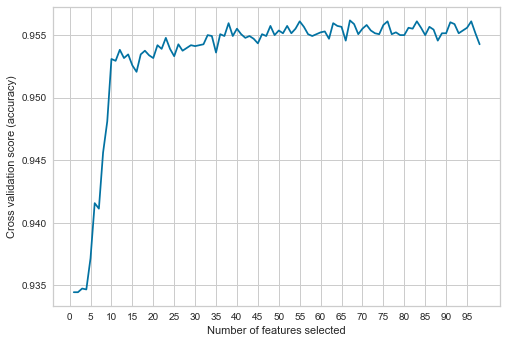

In [104]:
# let's visualize how number of features selected and accuracy

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_,
         markevery = [rfecv.n_features_-1])
plt.xticks(np.arange(0,100,5))
plt.savefig('FS.pdf', format='pdf')
plt.show()

In [49]:
# select all cols that have feature importance > 0.01

selected_cols = var[var['feature_importance'] > 0.01]['variable'].tolist()
print('# features selected:', len(selected_cols))
selected_cols

# features selected: 25


['HireYear--*--#_of_BusinessProcessType',
 '#_of_BusinessProcessType--^2',
 '#_of_job_family--*--#_of_BusinessProcessType',
 '#_of_OrgBus--*--#_of_BusinessProcessType',
 '#_of_BusinessProcessType/HireYear',
 '#_of_BusinessProcessType/#_of_OrgBus',
 '#_of_BusinessProcessType_log',
 '#_of_BusinessProcessType',
 '#_of_JobCDInst--*--#_of_BusinessProcessType',
 '#_of_BusinessProcessType--*--#_of_BusinessProcessReason',
 '#_of_BusinessProcessType/#_of_job_family',
 'Salary_Property_Hourly_Rate--*--#_of_BusinessProcessType',
 '#_of_BusinessProcessType/Salary_Property_Hourly_Rate',
 '#_of_BusinessProcessReason/HireYear',
 '#_of_JobCDInst--*--YearsOfService',
 'HireYear--*--#_of_OrgDiv',
 '#_of_BusinessProcessType--*--YearsOfService',
 '#_of_BusinessProcessReason--*--YearsOfService',
 'HireYear--*--#_of_BusinessProcessReason',
 '#_of_BusinessProcessType/Age',
 '#_of_BusinessProcessReason/Age',
 '#_of_JobCDInst--*--#_of_OrgDiv',
 'HireYear--*--#_of_JobCDInst',
 '#_of_JobCDInst/HireYear',
 '#_of_

## 3.3 L1 regularization - Embedded

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# using logistic regression with penalty l1.
selection = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver= 'liblinear'))
selection.fit(X_trn_tgt_scaled[selected_cols], y_train)

# see the selected features.
selected_features = X_trn_tgt_scaled[selected_cols].columns[(selection.get_support())]

# see the deleted features.
removed_features = X_trn_tgt_scaled[selected_cols].columns[(selection.estimator_.coef_ == 0).ravel().tolist()]

In [51]:
# number of features after regularization

len(selected_features)

13

In [52]:
# number of features removed after regularization

len(removed_features)

12

Finally, we will move on to model building with 13 features.

# **4. Model Building**

## 4.1 Baseline

In [53]:
X_trn = X_trn_tgt_scaled[selected_features]#.drop('EEID', axis = 1)
X_tst = X_tst_tgt_scaled[selected_features]#.drop('EEID', axis = 1)

In [54]:
def calculate_scores(model, X_trn, y_trn, X_tst, y_tst):
    """Calculate accuracy, roc-auc, and KS scores on the test set"""
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    accuracy = accuracy_score(y_tst, y_pred)

    y_pred_proba = model.predict_proba(X_tst)[:,1]
    auc = roc_auc_score(y_tst, y_pred_proba)

    mask = y_tst.astype(bool).values
    churn = y_pred_proba[mask]
    not_churn = y_pred_proba[~mask]
    ks = sps.ks_2samp(churn, not_churn)[0]
    
    return accuracy, auc, ks

def fit_first_level(models, X_trn, y_trn, X_tst):
    """
    Prepare first-level model fitting for stacking. Only used during model stacking.
    Output the predicted probabilities of the first-level models as features for the stacking model.
    """
    # create dataframes to store predictions of the first level models
    X2_trn = np.zeros((len(X_trn), 2 * len(models)))
    X2_tst = np.zeros((len(X_tst), 2 * len(models)))

    for i, (model, smote) in enumerate(models.values()):
        # if the selected model requires upsampling
        if smote:
            smote = SMOTE()
            X_trn_rs, y_trn_rs = smote.fit_sample(X_trn, y_trn)
        else:
            X_trn_rs, y_trn_rs = X_trn, y_trn

        model.fit(X_trn_rs, y_trn_rs)
        y_trn_pred_proba = model.predict_proba(X_trn)
        y_tst_pred_proba = model.predict_proba(X_tst)

        X2_trn[:, i*2:(i+1)*2] = y_trn_pred_proba
        X2_tst[:, i*2:(i+1)*2] = y_tst_pred_proba
    
    return X2_trn, X2_tst

def calculate_cv_scores(model, X, y, cv = 5, smote = True, stacking = False, models = None, verbose = False):
    """Calculate average k-fold cross-validated accuracy, roc-auc, and KS scores"""
    kf = KFold(n_splits = cv, shuffle = True)
    accuracy_scores = []
    auc_scores = []
    ks_scores = []
    fold_count = 0

    for train_index, test_index in kf.split(X):
        X_trn, X_tst = X.iloc[train_index], X.iloc[test_index]
        y_trn, y_tst = y.iloc[train_index], y.iloc[test_index]
        
        # Do not upsample when stacking models
        # Note that the first-level models used may incorperate SMOTE
        # Which is handled in the fit_first_level function
        if stacking:
            smote = False
            X_trn, X_tst = fit_first_level(models, X_trn, y_trn, X_tst)
            
        if smote:
            smote = SMOTE()
            X_trn, y_trn = smote.fit_sample(X_trn, y_trn)

        accuracy, auc, ks = calculate_scores(model, X_trn, y_trn, X_tst, y_tst)
        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        ks_scores.append(ks)
        
        if verbose:
            print(f"Fold {fold_count} accuracy, auc, ks:", accuracy, auc, ks)
        fold_count += 1

    return np.mean(accuracy_scores), np.mean(auc_scores), np.mean(ks_scores)

def fit_models_summary(models, X, y, cv = 5, smote = True):
    """
    Calculate average k-fold cross-validated accuracy, roc-auc, and KS scores for multiple models.
    Generate a summary dataframe sorted by roc-auc desending.
    If smote is True, each model will be additionally trained on upsampled train sets during cross validation.
    """
    baseline = pd.DataFrame(columns = ['accuracy', 'auc', 'ks'])
    
    for name, model in models.items():
        
        accuracy, auc, ks = calculate_cv_scores(model, X, y, cv = cv, smote = False)
        baseline.loc[name] = [accuracy, auc, ks]
        
        if smote:
            accuracy, auc, ks = calculate_cv_scores(model, X, y, cv = cv, smote = True)
            baseline.loc["{} (SMOTE)".format(name)] = [accuracy, auc, ks]
            
        print(f"{name} processed")
    
    baseline = baseline.sort_values('auc', ascending = False)
    
    return baseline

In [55]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'K Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Light GBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    "Neural Network": MLPClassifier(hidden_layer_sizes = (10,)),
#     'Support Vector Machine': SVC()
}

In [56]:
# test baseline models (default hyperparameters)
baseline = fit_models_summary(models, X_trn, y_train)

Logistic Regression processed
Decision Tree processed
K Nearest Neighbors processed
Random Forest processed
Gaussian Naive Bayes processed
Light GBM processed
XGBoost processed
Gradient Boosting processed
Neural Network processed


In [57]:
baseline

,accuracy,auc,ks
Light GBM (SMOTE),0.959021,0.995037,0.927002
Light GBM,0.958654,0.994935,0.923552
XGBoost,0.959020,0.994892,0.925924
XGBoost (SMOTE),0.957994,0.994619,0.924098
Gradient Boosting (SMOTE),0.953596,0.994075,0.918595
Gradient Boosting,0.957848,0.993938,0.915670
Random Forest,0.953816,0.991989,0.910857
Random Forest (SMOTE),0.955721,0.991136,0.911967
Neural Network (SMOTE),0.922660,0.972177,0.830910
Neural Network,0.932482,0.971285,0.833148


## 4.2 Model tuning

In [58]:
def get_paramsList(params_grid):
    """
    Create all possible combinations of params.
    Returns a list of all param names and a list of all param combinations.
    """
    allNames = sorted(params_grid)
    combinations = it.product(*(params_grid[Name] for Name in allNames))
    all_params = list(combinations)
    return allNames, all_params

In [59]:
def param_search(model, X, y, param_grid, verbose = True, scoring = 'ks', 
                 smote = True, stacking = False, models = None):
    """
    Brute force search through param_grid to find the optimal parameter combination based on the specified score type. 
    Can be used to search parameters for both stacking model and regular models.
    When stacking is True, SMOTE is disabled.
    scoring = ['accuracy', 'auc', 'ks']
    """
    param_names, all_params = get_paramsList(param_grid)
    print("Total combination:", len(all_params))
    best_score = 0
    best_param = None
    best_smote = None
    best_scores = None
    
    count = 0
    
    if stacking:
        smote = False
    
    if smote:
        smote_range = [True, False]
    else:
        smote_range = [False]

    for smote in smote_range:
        print(f"smote = {smote}")
        for cur_params in all_params:
            params = dict(zip(param_names, cur_params))
            model.set_params(**params)
            accuracy, auc, ks = calculate_cv_scores(model, X, y, smote = smote,
                                                    stacking = stacking, models = models)
            
            if verbose:
                print("\t", params, f"accuracy: {accuracy:.3f}, auc: {auc:.3f}, ks: {ks:.3f}")
            
            # choose which score to use
            if scoring == 'accuracy':
                score = accuracy
            elif scoring == "auc":
                score = auc
            else:
                score = ks
                
            if score > best_score:
                best_score = score
                best_param = params
                best_smote = smote
                best_scores = [accuracy, auc, ks]
            
            count += 1
            if count%10 == 0:
                print(f"{count} combinations searched")
    
    print("Best param:", best_param, f"smote = {best_smote}")
    print("Best scores (accuracy, auc, ks):", best_scores)
    return best_param, best_scores, best_smote

In [60]:
def smote_name(name, smote):
    """Adjust model name to include (SMOTE)"""
    if smote:
        return name + " (SMOTE)"
    return name

In [61]:
tuned_models = {}
tuned_summary = pd.DataFrame(columns = ['accuracy', 'auc', 'ks'])

### Logistic Regression

In [62]:
param_grid = {
    'C': [0.001,0.01,0.1,1,10,100, 1000]
}

model = LogisticRegression()
params, scores, smote = param_search(model, X_trn, y_train, param_grid, verbose = True)

Total combination: 7
smote = True
	 {'C': 0.001} accuracy: 0.921, auc: 0.846, ks: 0.752
	 {'C': 0.01} accuracy: 0.921, auc: 0.864, ks: 0.760
	 {'C': 0.1} accuracy: 0.927, auc: 0.910, ks: 0.779
	 {'C': 1} accuracy: 0.933, auc: 0.939, ks: 0.795
	 {'C': 10} accuracy: 0.930, auc: 0.951, ks: 0.800
	 {'C': 100} accuracy: 0.932, auc: 0.972, ks: 0.819
	 {'C': 1000} accuracy: 0.942, auc: 0.985, ks: 0.862
smote = False
	 {'C': 0.001} accuracy: 0.911, auc: 0.847, ks: 0.753
	 {'C': 0.01} accuracy: 0.923, auc: 0.852, ks: 0.756
	 {'C': 0.1} accuracy: 0.925, auc: 0.896, ks: 0.772
10 combinations searched
	 {'C': 1} accuracy: 0.930, auc: 0.932, ks: 0.795
	 {'C': 10} accuracy: 0.934, auc: 0.948, ks: 0.799
	 {'C': 100} accuracy: 0.935, auc: 0.966, ks: 0.805
	 {'C': 1000} accuracy: 0.936, auc: 0.979, ks: 0.839
Best param: {'C': 1000} smote = True
Best scores (accuracy, auc, ks): [0.9416467420096305, 0.9845821371248558, 0.8621846318113608]


In [63]:
name = 'Logistic Regression'
model.set_params(**params)
tuned_models[name] = (model, smote)
tuned_summary.loc[smote_name(name, smote)] = scores
tuned_summary

,accuracy,auc,ks
Logistic Regression (SMOTE),0.941647,0.984582,0.862185


### XGBoost

In [64]:
param_grid = {
    'max_depth': [4,6],
    'eta': [.2, .05],
    'min_child_weight' : [1, 4]
}

model = XGBClassifier()
params, scores, smote = param_search(model, X_trn, y_train, param_grid, verbose = True)

Total combination: 8
smote = True
	 {'eta': 0.2, 'max_depth': 4, 'min_child_weight': 1} accuracy: 0.957, auc: 0.995, ks: 0.922
	 {'eta': 0.2, 'max_depth': 4, 'min_child_weight': 4} accuracy: 0.959, auc: 0.995, ks: 0.919
	 {'eta': 0.2, 'max_depth': 6, 'min_child_weight': 1} accuracy: 0.960, auc: 0.995, ks: 0.924
	 {'eta': 0.2, 'max_depth': 6, 'min_child_weight': 4} accuracy: 0.959, auc: 0.995, ks: 0.925
	 {'eta': 0.05, 'max_depth': 4, 'min_child_weight': 1} accuracy: 0.959, auc: 0.995, ks: 0.922
	 {'eta': 0.05, 'max_depth': 4, 'min_child_weight': 4} accuracy: 0.958, auc: 0.995, ks: 0.920
	 {'eta': 0.05, 'max_depth': 6, 'min_child_weight': 1} accuracy: 0.959, auc: 0.995, ks: 0.921
	 {'eta': 0.05, 'max_depth': 6, 'min_child_weight': 4} accuracy: 0.959, auc: 0.995, ks: 0.924
smote = False
	 {'eta': 0.2, 'max_depth': 4, 'min_child_weight': 1} accuracy: 0.960, auc: 0.995, ks: 0.923
	 {'eta': 0.2, 'max_depth': 4, 'min_child_weight': 4} accuracy: 0.959, auc: 0.995, ks: 0.922
10 combinations se

In [65]:
name = 'XGBClassifier'
model.set_params(**params)
tuned_models[name] = (model, smote)
tuned_summary.loc[smote_name(name, smote)] = scores
tuned_summary

,accuracy,auc,ks
Logistic Regression (SMOTE),0.941647,0.984582,0.862185
XGBClassifier,0.961220,0.995038,0.926187


### LightGBM

In [66]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [.2, .05],
    'num_leaves' : [50, 80]
}

model = LGBMClassifier()
params, scores, smote = param_search(model, X_trn, y_train, param_grid, verbose = True)

Total combination: 8
smote = True
	 {'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 50} accuracy: 0.955, auc: 0.995, ks: 0.920
	 {'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 80} accuracy: 0.957, auc: 0.995, ks: 0.921
	 {'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 50} accuracy: 0.959, auc: 0.995, ks: 0.923
	 {'learning_rate': 0.2, 'max_depth': 5, 'num_leaves': 80} accuracy: 0.959, auc: 0.995, ks: 0.923
	 {'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 50} accuracy: 0.949, auc: 0.992, ks: 0.909
	 {'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 80} accuracy: 0.950, auc: 0.992, ks: 0.911
	 {'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 50} accuracy: 0.953, auc: 0.994, ks: 0.920
	 {'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 80} accuracy: 0.952, auc: 0.994, ks: 0.919
smote = False
	 {'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 50} accuracy: 0.960, auc: 0.995, ks: 0.919
	 {'learning_rate': 0.2, 'max_depth': 3, 'num_leaves': 80} accurac

In [67]:
name = 'LightGBM'
model.set_params(**params)
tuned_models[name] = (model, smote)
tuned_summary.loc[smote_name(name, smote)] = scores
tuned_summary

,accuracy,auc,ks
Logistic Regression (SMOTE),0.941647,0.984582,0.862185
XGBClassifier,0.961220,0.995038,0.926187
LightGBM,0.958874,0.994903,0.925392


# **5.  Classification report and model performance visualization**

#### After finding the best parameters for the models we have choosen, let's now visualize classification_report and model performance

In [ ]:
# conda install -c districtdatalabs yellowbrick

In [95]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from yellowbrick.classifier import DiscriminationThreshold


def classification_report_and_model_performance(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc)
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
     
    #plot roc curve
    trace1 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2),
                       )
    trace2 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot confusion matrix
    trace3 = go.Heatmap(z = conf_matrix ,x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Blues",name = "matrix",
                        xaxis = "x2",yaxis = "y2"
                       )
    
    layout = go.Layout(dict(title="Model performance" ,
                            autosize = False,height = 500,width = 800,
                            showlegend = False,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(title = "false positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         domain=[0, 0.6],
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(title = "true positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            margin = dict(b=200),
                            xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                        gridcolor = 'rgb(255, 255, 255)'),
                            yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                           )
                  )
    data = [trace1,trace2,trace3]
    fig = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

In [78]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

### LogReg

In [ ]:
# logreg = LogisticRegression(C = 1000)

# telecom_churn_prediction_alg(logreg,X_trn,X_tst,
#                              y_train,y_test,threshold_plot = True)

Pipeline(steps=[('over', SMOTE()), ('model', LogisticRegression(C=1000))])

 Classification report : 
               precision    recall  f1-score   support

           0       0.95      0.82      0.88      1385
           1       0.92      0.98      0.95      3163

    accuracy                           0.93      4548
   macro avg       0.94      0.90      0.91      4548
weighted avg       0.93      0.93      0.93      4548

Accuracy Score   :  0.9302990325417766
Area under curve :  0.8985472823748418


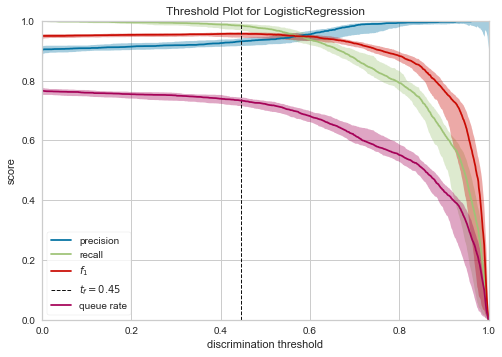

In [96]:
steps = [('over', SMOTE()), ('model', LogisticRegression(C = 1000))]
pipeline = Pipeline(steps=steps)

classification_report_and_model_performance(pipeline,X_trn,X_tst,
                             y_train,y_test,threshold_plot = True)

### XGB

[19:00:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { smote } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, smote=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Classification report : 
 

[19:00:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { smote } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:00:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { smote } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:01:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { smote } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

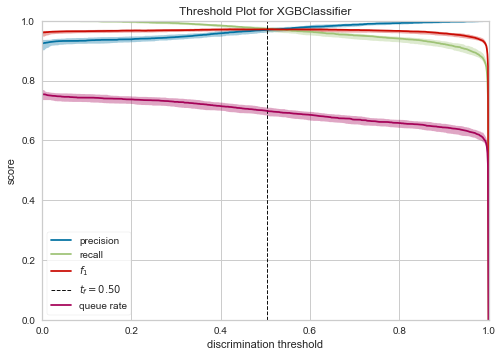

In [97]:
model = XGBClassifier(max_depth = 6, eta = 0.2, min_child_weight = 1, smote = True)
classification_report_and_model_performance(model,X_trn,X_tst,
                             y_train,y_test,threshold_plot = True)

### LightGBM

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
LGBMClassifier(eta=0.2, max_depth=5, num_leaves=80)

 Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1385
           1       0.96      0.97      0.97      3163

    accuracy                           0.95      4548
   macro avg       0.95      0.94      0.95      4548
weighted avg       0.95      0.95      0.95      4548

Accuracy Score   :  0.9547053649956024
Area under curve :  0.9422722795499863


[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.2 

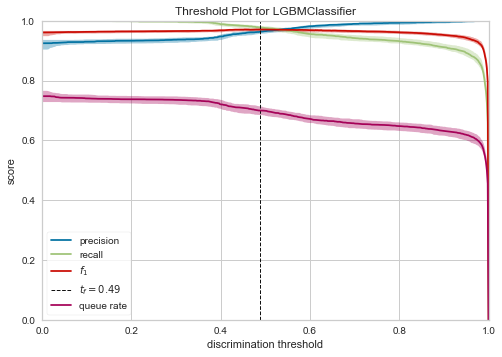

In [90]:
lgb = LGBMClassifier(max_depth = 5, eta = 0.2, num_leaves = 80)
classification_report_and_model_performance(lgb, X_trn,X_tst,
                             y_train,y_test,threshold_plot = True)

## Stacking Model

In [91]:
stack_model = XGBClassifier(max_depth = 3)
accuracy, auc, ks = calculate_cv_scores(stack_model, X_trn, y_train, 
                                        stacking = True, models = tuned_models, 
                                        verbose = True)
print('Stacking baseline:')
print('Accuracy:', accuracy)
print('AUC:', auc)
print('KS:', ks)

Fold 0 accuracy, auc, ks: 0.9552949798460975 0.9905266358852148 0.9186029192731605
Fold 1 accuracy, auc, ks: 0.9567448680351907 0.9924844590565218 0.9227339571566396
Fold 2 accuracy, auc, ks: 0.9560117302052786 0.992777142130689 0.9216069158403255
Fold 3 accuracy, auc, ks: 0.9589442815249267 0.9932618825125769 0.9216285410719544
Fold 4 accuracy, auc, ks: 0.9629765395894428 0.9904007804892893 0.9252069133398247
Stacking baseline:
Accuracy: 0.9579944798401872
AUC: 0.9918901800148582
KS: 0.921955849336381


In [92]:
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3],
    'subsample': [0.9]
}

model = XGBClassifier()
params, scores, _ = param_search(model, X_trn, y_train, param_grid, verbose = True, scoring = 'ks', 
                                 smote = False, stacking = True, models = tuned_models)

Total combination: 4
smote = False
	 {'eta': 0.01, 'max_depth': 3, 'subsample': 0.9} accuracy: 0.959, auc: 0.989, ks: 0.926
	 {'eta': 0.05, 'max_depth': 3, 'subsample': 0.9} accuracy: 0.959, auc: 0.988, ks: 0.921
	 {'eta': 0.1, 'max_depth': 3, 'subsample': 0.9} accuracy: 0.958, auc: 0.988, ks: 0.922
	 {'eta': 0.2, 'max_depth': 3, 'subsample': 0.9} accuracy: 0.960, auc: 0.989, ks: 0.923
Best param: {'eta': 0.01, 'max_depth': 3, 'subsample': 0.9} smote = False
Best scores (accuracy, auc, ks): [0.9593137786928494, 0.9888688614644148, 0.9259341472291209]


In [93]:
name = 'Stacking Model (XGB)'
stack_model = XGBClassifier(**params)
tuned_summary.loc[name] = scores
tuned_summary

,accuracy,auc,ks
Logistic Regression (SMOTE),0.941647,0.984582,0.862185
XGBClassifier,0.961220,0.995038,0.926187
LightGBM,0.958874,0.994903,0.925392
Stacking Model (XGB),0.959314,0.988869,0.925934


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      1385
           1       0.93      1.00      0.96      3163

    accuracy                           0.94      4548
   macro avg       0.96      0.91      0.93      4548
weighted avg       0.95      0.94      0.94      4548

Accuracy Score   :  0.9428320140721196
Area under

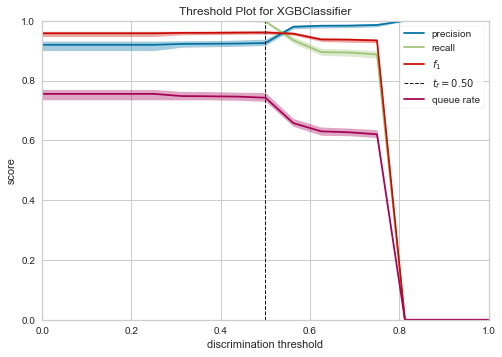

In [94]:
xgb_stacking = XGBClassifier(max_depth = 3, eta = 0.01, subsample = 0.9)
classification_report_and_model_performance(xgb_stacking, X_trn,X_tst,
                             y_train,y_test,threshold_plot = True)

# ** 6. Final Remarks - Recommendation**

- The performance of the four models are not very different from each other. For computation and interpretability concerns, the Logistic Regression model with upsampling method is recommended.


#### NOTE:
This is not imagined to be a 'black box' type of solution. This model can help in approximating for example the following:



1. **Workforce planning**: What percantage of a certain cohort is 'at risk of leaving' a company soon?

2. **Top Talent Retention**: Let's say that someone who you consider to be a top talent is 'labeled' as someone who is 'at risk of leaving' a company. That info might help HR Department to be proactive and offer salary increase & other incentives to try to retain top talent.

3. **What-If analysis**: This analysis showed that reducing Employee Turnover 1% is associated with saving 1 - 2 million dollars in Cost of Employee Turnover.


#### Additional materials

- Check .pptx that is provided
- Check What-If analysis in Tableau